# Study 2 
### *How effective are conventional algorithms for state and parameter estimation in addressing networks with sparse measurements?*

For an observable network with $n$ states and $m$ measurements, the redundancy $\eta$ can be defined as $\frac{m}{n}$. The quality of the state-estimates can be evaluated using the residual vector $\mathbf{r}$. The effectiveness of conventional SPE algorithms, such as the method of residual analysis and the method of state-vector augmentation, can be assessed by analysing the functional relationship between the magnitude of the residual vector $|\mathbf{r}|$ and the redundancy $\eta$. Specifically, 

$$
    |\mathbf{r}| = f(\eta),
$$

where, $f(\cdot)$ is a function that uses number of measurements sampled with redundancy $\eta$ as the input and performs conventional SPE for the case-study networks. This analysis will quantify the effectiveness of the conventional algorithms and will aid in comparing them with the proposed method. 


### Methodology
[1. Load synthetic networks (see RQ 1).](#section-title1)

[2. Run power flow for the loaded network once and reuse them for consistent results.](#section-title2)

[3. Function definition with input as redundancy and output as residual vector or RMSE as a performance metric.](#section-title3)

[4. Plot $\eta$ vs. $|r|$ curve.](#section-title4)


In [1]:
import pandapower as pp 
# from utils import custom_se
from typing import Tuple, Dict, List 
import os 
import sys 
import numpy as np
import random
import matplotlib.pyplot as plt 
import joblib
from ipywidgets import widgets



# for complex numbers printing
np.set_printoptions(formatter={'complex_kind': '{:.2f}'.format})

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(parent_dir)
sys.path.insert(0, parent_dir)

from utils.ppnet_utils import use_stored_pfr, custom_se

# for consistent results 
seed = 1740569069 # int(time.time())
random.seed(seed)
np.random.seed(seed)
print(seed)


/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN
1740569069


<a id="section-title1"></a>
### 1. Load synthetic networks (see RQ 1).

In [2]:
net = pp.networks.mv_oberrhein(include_substations=True)
net.name ="MVO"
print("MVO selected.")

MVO selected.


<a id="section-title2"></a>
### 2. Run power flow for the loaded network once and reuse them for consistent results.

In [4]:
vm_pfr, va_pfr, p_pfr, q_pfr, p_pfr_line  = use_stored_pfr(net, 
                                                           parent_dir=parent_dir)

pfr_dict = {'vm_pfr': vm_pfr, 
            'va_pfr': va_pfr,
            'p_pfr': p_pfr,
            'q_pfr': q_pfr,
            'p_pfr_line':p_pfr_line}

Loaded pkls


<a id="section-title3"></a>
### 3. Function definition with input as redundancy and output as residual vector or RMSE as a performance metric.

In [6]:
def eta_rmse(net: pp.pandapowerNet, 
              pfr_dict: Dict,
              eta: float)->Tuple[List,float]:
    """
    Function to investigate the relation between measurement 
    redundancy and state-parameter estimation residual or RMSE. 
    Input: 
        eta: redundancy = [1,]
    """

    v_pfr = np.array(pfr_dict['vm_pfr'])
    va_pfr = np.array(pfr_dict['va_pfr'])
    p_pfr = np.array(pfr_dict['p_pfr'])
    q_pfr = np.array(pfr_dict['q_pfr'])
    p_pfr_line = np.array(pfr_dict['p_pfr_line'])

    # state-estimation 
    net_meas = custom_se(net=net, 
                         pfr_dict=pfr_dict,
                         se_iter=20, 
                         is_for_rq2=True, 
                         prob_lq_meas=eta)

   
    eta = net_meas.eta

    # z_v = net_meas.measurement[net_meas.measurement.measurement_type == 'v'].value
    # z_p = net_meas.measurement[(net.measurement.measurement_type == 'p') & (net.measurement.element_type == 'bus')].value
    # z_q = net_meas.measurement[net_meas.measurement.measurement_type == 'q'].value

    # calculate residuals of voltage and reactive power required for parameter estimation  
    res_mag_v = np.sqrt(np.mean((v_pfr - np.array(net_meas.res_bus_est.vm_pu))**2)) # voltage residuals
    res_mag_a = np.sqrt(np.mean((va_pfr - np.array(net_meas.res_bus_est.va_degree))**2))
    res_mag_p = np.sqrt(np.mean((p_pfr - np.array(net_meas.res_bus_est.p_mw))**2))
    res_mag_q = np.sqrt(np.mean((q_pfr - np.array(net_meas.res_bus_est.q_mvar))**2))

    # res_mag_v = np.sqrt(np.mean((z_v - np.array(net_meas.res_bus_est.vm_pu))**2)) # voltage residuals
    # res_mag_a = np.sqrt(np.mean((va_pfr - np.array(net_meas.res_bus_est.va_degree))**2))
    # res_mag_p = np.sqrt(np.mean((z_p - np.array(net_meas.res_bus_est.p_mw))**2))
    # res_mag_q = np.sqrt(np.mean((q_pfr - np.array(net_meas.res_bus_est.q_mvar))**2))

    
    return res_mag_v, res_mag_a, res_mag_p, res_mag_q, eta 


In [7]:
psp_list = np.linspace(0.1,1,10)

wls_rmse_list_v = np.zeros_like(psp_list)
wls_rmse_list_a = np.zeros_like(psp_list)
wls_rmse_list_p = np.zeros_like(psp_list)
wls_rmse_list_q = np.zeros_like(psp_list)
redundancy_list = np.zeros_like(psp_list)


for i, eta in enumerate(psp_list):
    wls_rmse_list_v[i],wls_rmse_list_a[i],wls_rmse_list_p[i],wls_rmse_list_q[i], redundancy_list[i] = eta_rmse(net, pfr_dict, eta) 

/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/create.py:6057: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  net[table].at[index, col] = val
/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/create.py:6057: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  net[table].at[index, col] = val
/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/create.py:6057: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version o

Total line measurements = 20
Reactive power measurements = 33
Redundancy = 1.0845070422535212.


/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation not successful (10/10 iterations)


State estimation successful for MVO!
Total number of measurements = 693 and number of measurements should be at least 639


ValueError: operands could not be broadcast together with shapes (320,) (0,) 

In [9]:
redundancy_list

array([1.08450704, 1.1627543 , 1.26134585, 1.27856025, 1.39123631,
       1.4741784 , 1.56338028, 1.62128326, 1.69327074, 1.7856025 ])

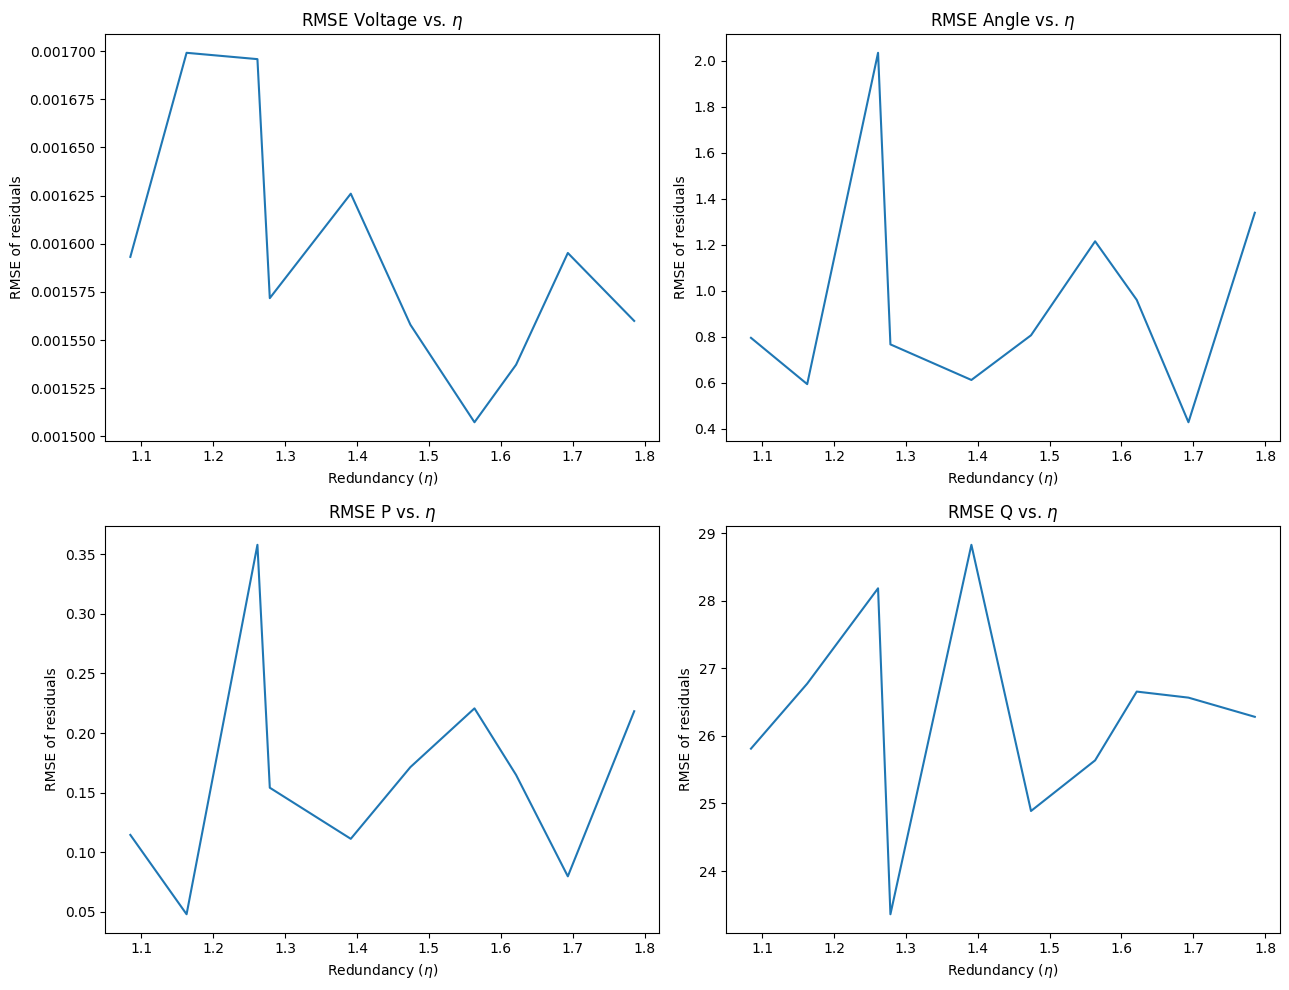

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

ax[0, 0].plot(redundancy_list, wls_rmse_list_v)
ax[0, 0].set_xlabel("Redundancy ($\eta$)")
ax[0, 0].set_ylabel("RMSE of residuals")
ax[0, 0].set_title("RMSE Voltage vs. $\eta$")

ax[0, 1].plot(redundancy_list, wls_rmse_list_a)
ax[0, 1].set_xlabel("Redundancy ($\eta$)")
ax[0, 1].set_ylabel("RMSE of residuals")
ax[0, 1].set_title("RMSE Angle vs. $\eta$")

ax[1, 0].plot(redundancy_list, wls_rmse_list_p)
ax[1, 0].set_xlabel("Redundancy ($\eta$)")
ax[1, 0].set_ylabel("RMSE of residuals")
ax[1, 0].set_title("RMSE P vs. $\eta$")

ax[1, 1].plot(redundancy_list, wls_rmse_list_q)
ax[1, 1].set_xlabel("Redundancy ($\eta$)")
ax[1, 1].set_ylabel("RMSE of residuals")
ax[1, 1].set_title("RMSE Q vs. $\eta$")

plt.tight_layout()
plt.savefig(parent_dir + f'/notebooks/rq2_results/RQ2_net_{net.name}.png')
plt.show()
